In [1]:
from product_sub.infrastructure.dataset_builder import DatasetBuilder
from product_sub.domain.data_cleaning import NumImputer, CatImputer
from product_sub.domain.feature_creator import CategoricalCreatorFromNumerical, CategoricalFeatureCreator
from product_sub.domain.feature_encoder import OneHotEncoder, FrequencyEncoder

import product_sub.settings as stg

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline,  make_pipeline, make_union
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

import numpy as np
import pandas as pd


RANDOM_STATE=42

### Create Dataset

In [4]:
len(stg.FINAL_COLUMNS)

36

In [5]:
dataset_merged = DatasetBuilder(
    filename_bank="data.csv", filename_socio="socio_eco.csv"
).create_dataset()
X = dataset_merged.drop(columns=stg.COL_RAW_SUBSCRIPTION)
y = dataset_merged[stg.COL_RAW_SUBSCRIPTION].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Pipeline

In [7]:
numeric_transformer = Pipeline(
        steps=[
            ("num_imputer", NumImputer()),
            (
                "create_categorical",
                CategoricalCreatorFromNumerical(stg.DICT_TO_CREATE_COLS),
            ),
            ("scaler", MinMaxScaler()),
        ]
    )
categorical_transformer = Pipeline(
    steps=[
        ("cat_imputer", CatImputer()),
        ("cat_creator", CategoricalFeatureCreator()),
        (
            "freq_encoder",
            FrequencyEncoder(stg.COLS_TO_FREQ_ENCODE),
        ),
        ("one_hot_encoder", OneHotEncoder([stg.COL_RAW_JOB])),
    ]
)
# preprocessor.transformers[1][1].steps[3][1].categories_
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)
clf = Pipeline(steps=[ ('preprocessor' , preprocessor),
                           ('rf',  RandomForestClassifier()) ])

In [8]:

grid_params_rf = [{
                'rf__criterion': ['entropy','gini'],
                'rf__min_samples_leaf': [40, 80, 100],
                'rf__max_depth': [15,25, 27],
                'rf__min_samples_split': [3, 5, 10],
                'rf__n_estimators' : [60, 70]
                }]
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=RANDOM_STATE)
search = GridSearchCV(clf, grid_params_rf, n_jobs=-1)
search.fit(X_train, y_train)


      MONTH  WEEKDAY  is_first_campaign  nb_contact_last_campaign_inf_4  \
1882      5        4                  1                               0   
8363      6        2                  1                               0   
3286      5        3                  1                               0   

      nb_contact_last_campaign_inf_8  nb_contact_last_campaign_inf_12  \
1882                               0                                0   
8363                               0                                0   
3286                               0                                0   

      nb_contact_last_campaign_sup_12  
1882                                0  
8363                                0  
3286                                0  


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          NumImputer()),
                                                                                         ('create_categorical',
                                                                                          CategoricalCreatorFromNumerical(array_with_dicts_with_bounds=[{'column_dist': 'is_first_campaign',
                                                                                                                                                         'column_source': 'NB_CONTACT_LAST_CAMPAIGN',
                                                                                                                                                         'i

In [9]:
search.best_score_

0.9045118644042404

In [10]:
search.score(X_test, y_test)

       MONTH  WEEKDAY  is_first_campaign  nb_contact_last_campaign_inf_4  \
4215       5        1                  1                               0   
30490      4        2                  1                               0   
8374       6        2                  1                               0   

       nb_contact_last_campaign_inf_8  nb_contact_last_campaign_inf_12  \
4215                                0                                0   
30490                               0                                0   
8374                                0                                0   

       nb_contact_last_campaign_sup_12  
4215                                 0  
30490                                0  
8374                                 0  


0.9000692360950843

In [11]:
search.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 27,
 'rf__min_samples_leaf': 40,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 70}

In [12]:
clf = Pipeline(steps=[ ('preprocessor' , preprocessor),
                           ('rf',  RandomForestClassifier(criterion='gini', max_depth=27, min_samples_leaf=40, min_samples_split=10, n_estimators=70)) ])
rdf = clf.fit(X_train, y_train)

      MONTH  WEEKDAY  is_first_campaign  nb_contact_last_campaign_inf_4  \
1882      5        4                  1                               0   
8363      6        2                  1                               0   
3286      5        3                  1                               0   

      nb_contact_last_campaign_inf_8  nb_contact_last_campaign_inf_12  \
1882                               0                                0   
8363                               0                                0   
3286                               0                                0   

      nb_contact_last_campaign_sup_12  
1882                                0  
8363                                0  
3286                                0  


In [13]:
rdf[1].feature_importances_.shape

(36,)

In [14]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [16]:
FINAL_COLUMNS = [
    stg.COL_RAW_AGE,
    stg.COL_RAW_HAS_DEFAULT,
    stg.COL_RAW_BALANCE,
    stg.COL_RAW_HAS_HOUSING_LOAN,
    stg.COL_RAW_HAS_PERSO_LOAN,
    stg.COL_RAW_DURATION_CONTACT,
    stg.COL_RAW_NB_CONTACT,
    stg.COL_RAW_NB_DAY_LAST_CONTACT,
    stg.COL_RAW_NB_CONTACT_LAST_CAMPAIGN,
    stg.COL_RAW_EMPL_VAR_RATE,
    stg.COL_RAW_IDX_CSMR_PRICE,
    stg.COL_RAW_IDX_CSMR_CONFIDENCE,
    stg.COL_MONTH,
    stg.COL_WEEKDAY,
    "is_first_campaign",
    "nb_contact_last_campaign_inf_4",
    "nb_contact_last_campaign_inf_8",
    "nb_contact_last_campaign_inf_12",
    "nb_contact_last_campaign_sup_12",
    stg.COL_RAW_STATUS,
    stg.COL_RAW_EDUCATION,
    stg.COL_RAW_CONTACT,
    "is_last_campaign_success",
    "is_last_campaign_fail",
    "Admin",
    "Chomeur",
    "Col bleu",
    "Employe de menage",
    "Entrepreneur",
    "Etudiant",
    "Independant",
    "Manager",
    "Retraite",
    "Services",
    "Technicien",
    "Autre",
]

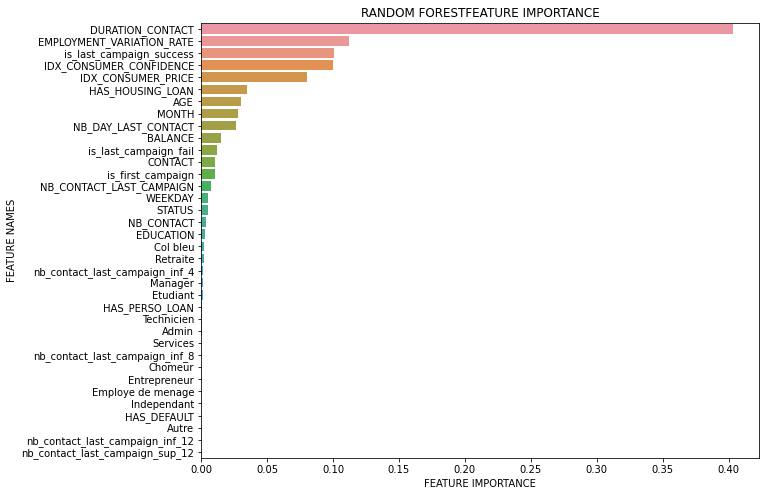

In [17]:
plot_feature_importance(rdf[1].feature_importances_,FINAL_COLUMNS,'RANDOM FOREST')